# Covid-19 Extension Project

Extension Project on Covid Data. Explanations of relevant graphs and their analyses are in the report.

Note: This notebook was curated for use with the final report as a more polished combination/distillation of our work. Some less interesting or important analysis is left out for brevity, but is available in the original project notebooks.

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [122]:
a80 = pd.read_csv("../data/cleaned_a80.csv")
abp = pd.read_csv("../data/cleaned_abp.csv")
zba = pd.read_csv("../data/cleaned_zba.csv")
covid_m = pd.read_csv("../data/cleaned_covid.csv")

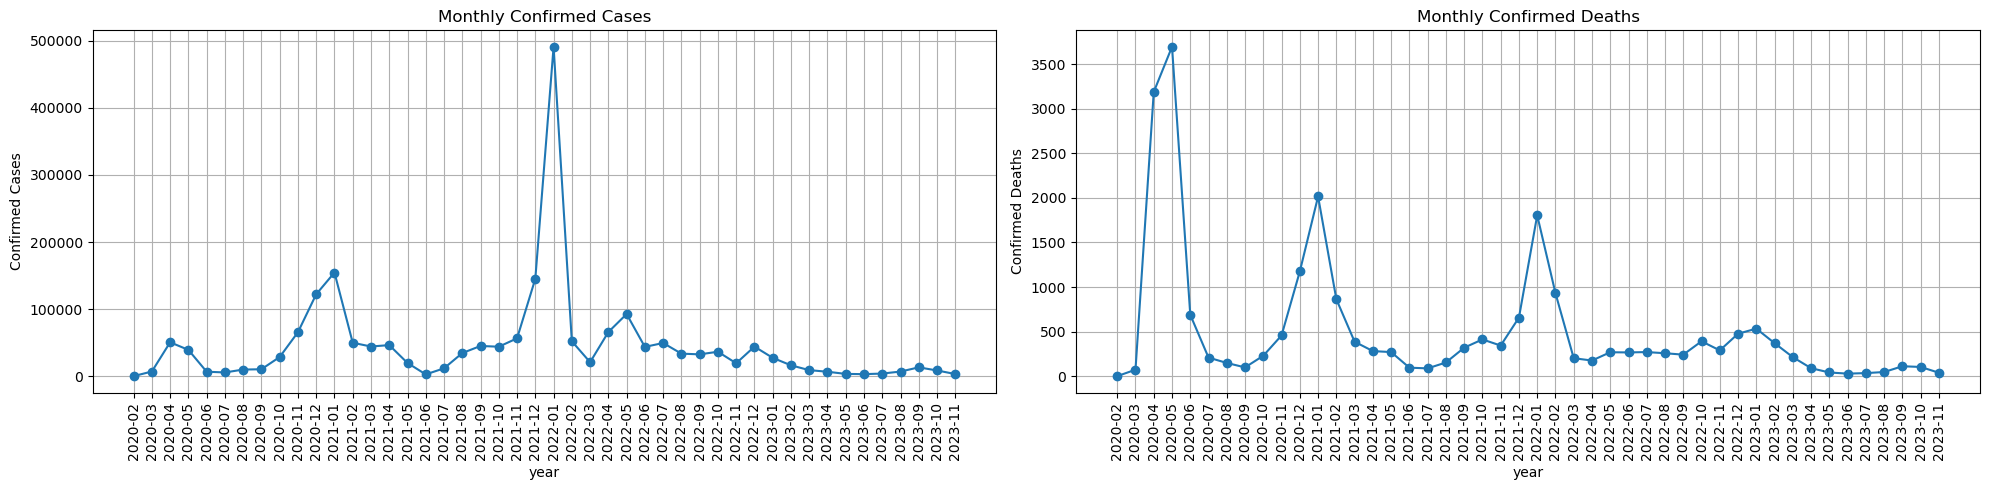

In [123]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(covid_m['date'], covid_m['Confirmed cases'], marker='o', linestyle='-')
plt.title('Monthly Confirmed Cases')
plt.xlabel('year')
plt.ylabel('Confirmed Cases')
plt.xticks(rotation=90)
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(covid_m['date'], covid_m['Confirmed deaths'], marker='o', linestyle='-')
plt.title('Monthly Confirmed Deaths')
plt.xlabel('year')
plt.ylabel('Confirmed Deaths')
plt.xticks(rotation=90)
plt.grid(True)

plt.tight_layout()
plt.show()

In [124]:
# Extract year and month into a new column
abp['issued_year_month'] = abp['year'].astype(str) + '-' + abp['month'].astype(str)
covid_abp = abp[['issued_year_month']]

In [125]:
project_count = covid_abp.groupby('issued_year_month').size().reset_index(name='project_count')
covid_m.rename(columns={'date': 'covid_issue_year_month'}, inplace=True)
project_count.rename(columns={'issued_year_month': 'covid_issue_year_month'}, inplace=True)
project_count['covid_issue_year_month'] = pd.to_datetime(project_count['covid_issue_year_month'], errors='coerce')
project_count['covid_issue_year_month'] = project_count['covid_issue_year_month'].dt.to_period('M')
covid_m['covid_issue_year_month'] = pd.to_datetime(covid_m['covid_issue_year_month'].apply(str)).dt.to_period('M')
covid_vs_abp = pd.merge(covid_m, project_count, on='covid_issue_year_month', how='left')

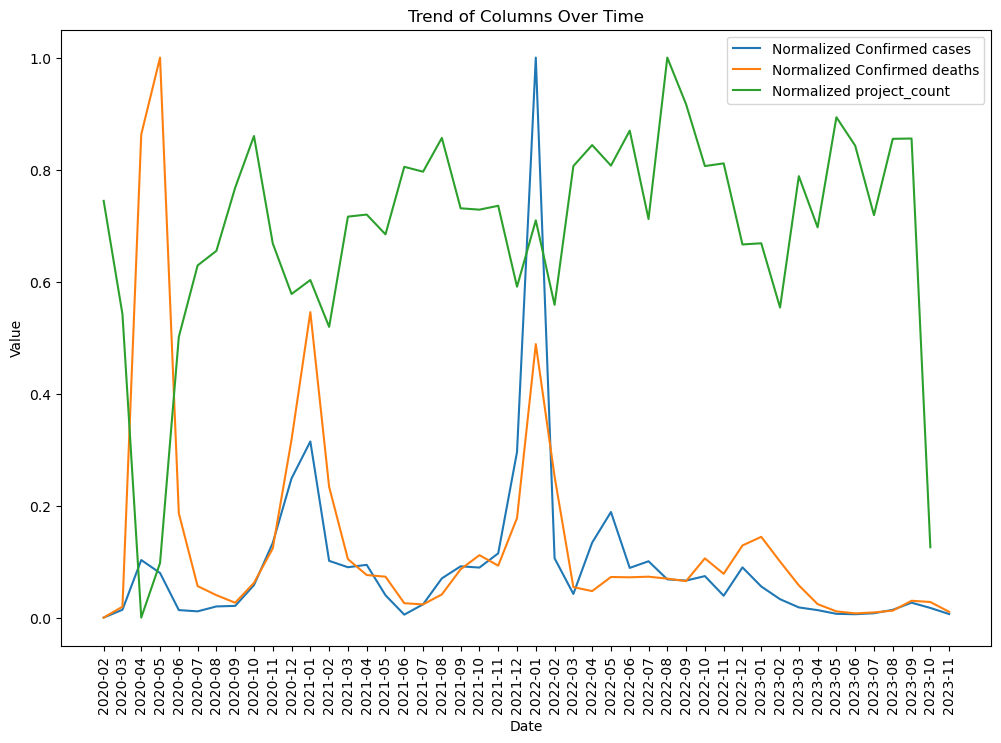

In [126]:
# Group by 'date' and normalize 'number_of_projects' and 'confirmed_covid_cases' within each group
scaler = MinMaxScaler()
columns_to_normalize = covid_vs_abp.columns[covid_vs_abp.columns != 'covid_issue_year_month']
plt.figure(figsize=(12, 8))
for column in columns_to_normalize:
    column_data = covid_vs_abp[column].values.reshape(-1, 1)  # Reshape to a 2D array for MinMaxScaler
    normalized_data = scaler.fit_transform(column_data)
    covid_vs_abp[f'normalized_{column}'] = normalized_data.flatten()
    # Plot original and normalized columns
    
    plt.plot(covid_vs_abp['covid_issue_year_month'].astype(str), normalized_data, label=f'Normalized {column}')
# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trend of Columns Over Time')
plt.legend()  # Show legend
#plt.gcf().autofmt_xdate()
# Display the plot
plt.xticks(rotation='vertical')
plt.show()

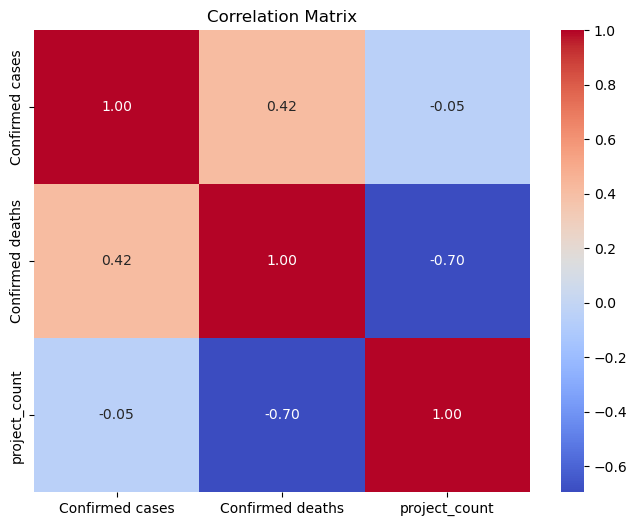

In [127]:
# Calculate the correlation matrix
correlation_matrix = covid_vs_abp[['Confirmed cases', 'Confirmed deaths', 'project_count']].corr()

# Create a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

In [128]:
zba['issued_year_month'] = pd.to_datetime(zba['year'].astype(str) + '-' + zba['month'].astype(str), errors='coerce')
zba['issued_year_month'] = zba['issued_year_month'].dt.to_period('M')

covid_zba = zba[["issued_year_month", "decision"]]

In [129]:
covid_zba = covid_zba[['issued_year_month', 'decision']]

# Group by 'issued_year_month' and 'decision', then count the occurrences
covid_vs_zba = covid_zba.groupby(['issued_year_month', 'decision']).size().unstack(fill_value=0)

# Reset index to have 'issued_year_month' as a column instead of an index
covid_vs_zba.reset_index(inplace=True)

# Create separate columns for 'approved' and 'denied' counts
covid_vs_zba['approved'] = covid_vs_zba['Approved']
covid_vs_zba['denied'] = covid_vs_zba['Denied']

# Drop unnecessary columns
covid_vs_zba.drop(columns=['Approved', 'Denied'], inplace=True)
covid_vs_zba = covid_vs_zba[['issued_year_month', 'approved', 'denied', 'Withdrawn']]

In [130]:
covid_vs_zba.rename(columns={'issued_year_month': 'covid_issue_year_month'}, inplace=True)
covid_vs_zba = pd.merge(covid_m, covid_vs_zba, on='covid_issue_year_month', how='left')


In [131]:
covid_vs_zba['ratio'] = covid_vs_zba['approved'] / np.where(covid_vs_zba['denied'] != 0, covid_vs_zba['denied'], 1)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Columns to normalize excluding 'covid_issue_year_month' and 'ratio'
columns_to_normalize = covid_vs_zba.columns[(covid_vs_zba.columns != 'covid_issue_year_month')]

# Plot original and normalized columns
plt.figure(figsize=(12, 8))
for column in columns_to_normalize:
    column_data = covid_vs_zba[column].fillna(0).values.reshape(-1, 1)  # Replace NaN with 0 and reshape for MinMaxScaler
    normalized_data = scaler.fit_transform(column_data)
    covid_vs_zba[f'normalized_{column}'] = normalized_data.flatten()
    
    # Plot original and normalized columns

<Figure size 1200x800 with 0 Axes>

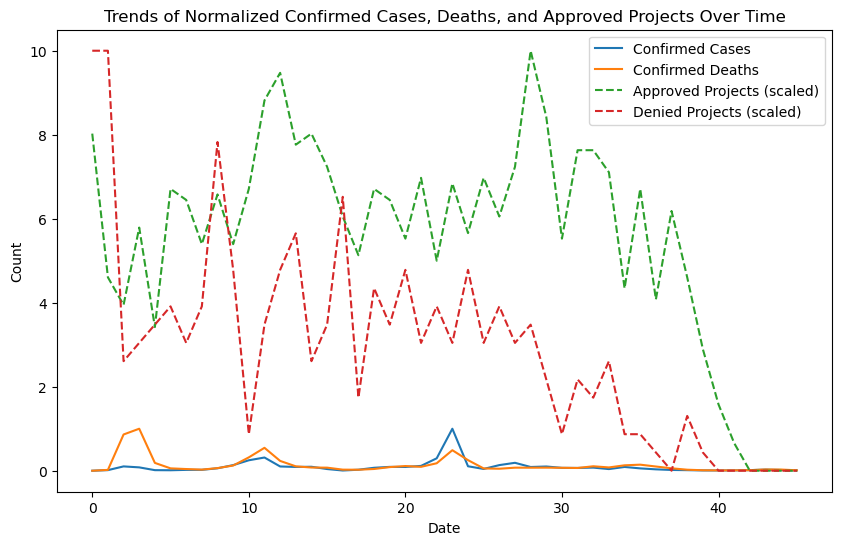

In [132]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot confirmed cases over time
plt.plot(covid_vs_zba.index, covid_vs_zba['normalized_Confirmed cases'], label='Confirmed Cases')

# Plot confirmed deaths over time
plt.plot(covid_vs_zba.index, covid_vs_zba['normalized_Confirmed deaths'], label='Confirmed Deaths')

# Plot approved projects over time (scaled for better visualization)
plt.plot(covid_vs_zba.index, covid_vs_zba['normalized_approved'] * 10, label='Approved Projects (scaled)', linestyle='--')

# Plot approved projects over time (scaled for better visualization)
plt.plot(covid_vs_zba.index, covid_vs_zba['normalized_denied'] * 10, label='Denied Projects (scaled)', linestyle='--')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Trends of Normalized Confirmed Cases, Deaths, and Approved Projects Over Time')
plt.legend()  # Show legend

# Display the plot
plt.show()

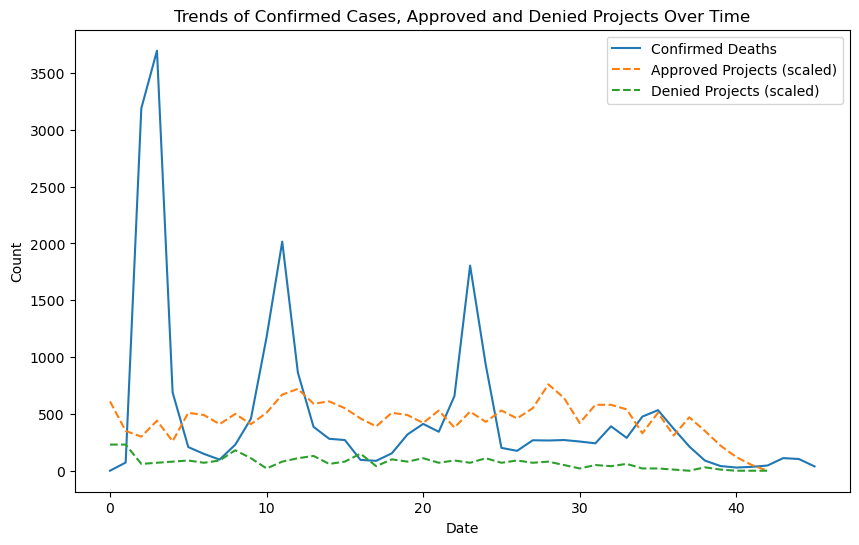

In [133]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot confirmed deaths over time
plt.plot(covid_vs_zba.index, covid_vs_zba['Confirmed deaths'], label='Confirmed Deaths')

# Plot approved projects over time (scaled for better visualization)
plt.plot(covid_vs_zba.index, covid_vs_zba['approved'] * 10, label='Approved Projects (scaled)', linestyle='--')

# Plot approved projects over time (scaled for better visualization)
plt.plot(covid_vs_zba.index, covid_vs_zba['denied'] * 10, label='Denied Projects (scaled)', linestyle='--')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Trends of Confirmed Cases, Approved and Denied Projects Over Time')
plt.legend()  # Show legend

# Display the plot
plt.show()

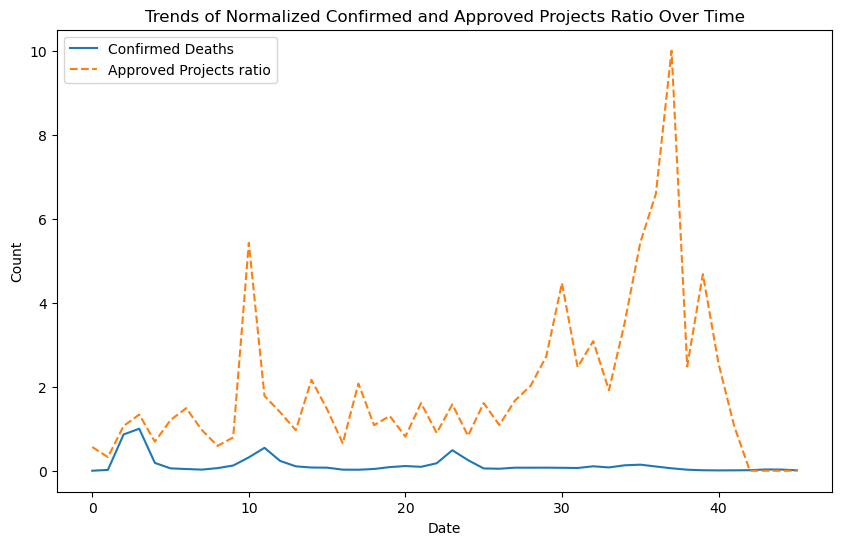

In [134]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot confirmed deaths over time
plt.plot(covid_vs_zba.index, covid_vs_zba['normalized_Confirmed deaths'], label='Confirmed Deaths')

# Plot approved projects over time (scaled for better visualization)
plt.plot(covid_vs_zba.index, covid_vs_zba['normalized_ratio'] * 10, label='Approved Projects ratio', linestyle='--')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Trends of Normalized Confirmed and Approved Projects Ratio Over Time')
plt.legend()  # Show legend

# Display the plot
plt.show()

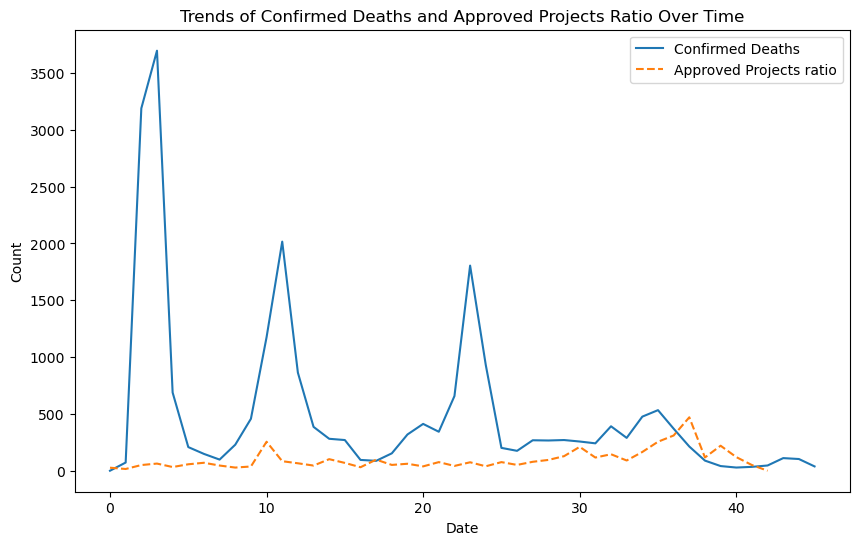

In [135]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot confirmed deaths over time
plt.plot(covid_vs_zba.index, covid_vs_zba['Confirmed deaths'], label='Confirmed Deaths')

# Plot approved projects over time (scaled for better visualization)
plt.plot(covid_vs_zba.index, covid_vs_zba['ratio'] * 10, label='Approved Projects ratio', linestyle='--')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Trends of Confirmed Deaths and Approved Projects Ratio Over Time')
plt.legend()  # Show legend

# Display the plot
plt.show()

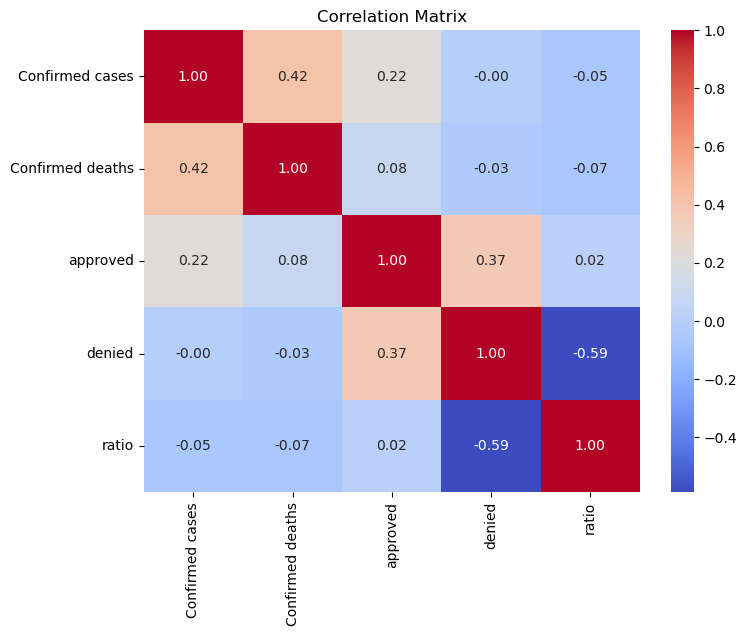

In [136]:
# Calculate the correlation matrix
correlation_matrix = covid_vs_zba[['Confirmed cases', 'Confirmed deaths', 'approved', 'denied', 'ratio']].corr()

# Create a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

In [137]:
# Assuming 'projects' is the column for number of projects and 'covid_deaths' is the column for COVID deaths
covid_vs_abp.dropna(axis=0, inplace=True)
X = covid_vs_abp[['Confirmed deaths']]  # Independent variable (number of projects)
y = covid_vs_abp['project_count']  # Dependent variable (COVID deaths)

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          project_count   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     40.27
Date:                Fri, 15 Dec 2023   Prob (F-statistic):           1.15e-07
Time:                        22:19:22   Log-Likelihood:                -346.94
No. Observations:                  45   AIC:                             697.9
Df Residuals:                      43   BIC:                             701.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3861.1528     99.282  

In [138]:
# Assuming 'projects' is the column for number of projects and 'covid_deaths' is the column for COVID deaths
covid_vs_abp.dropna(axis=0, inplace=True)
X = covid_vs_abp[['Confirmed cases']]  # Independent variable (number of projects)
y = covid_vs_abp['project_count']  # Dependent variable (COVID deaths)

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          project_count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.1090
Date:                Fri, 15 Dec 2023   Prob (F-statistic):              0.743
Time:                        22:19:22   Log-Likelihood:                -361.76
No. Observations:                  45   AIC:                             727.5
Df Residuals:                      43   BIC:                             731.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3531.7075    133.950     